In [73]:
import os 
import glob 
import cv2 
import numpy as np 
import datetime 
import matplotlib.pyplot as plt 
import random 
import time 
import yolov5 

In [74]:
%matplotlib inline

In [75]:
# constants from kitti
baseline = 0.54  # [m]
focal_length = 721 # pixel

stereo_dir = "/data/kitti/stereo/training"
imgs_left = glob.glob(os.path.join(stereo_dir, "image_2") + "/*.png")
imgs_right = glob.glob(os.path.join(stereo_dir, "image_3") + "/*.png")

In [76]:
def compute_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=True):
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11

    if matcher == 'bm':
        stereo_matcher = cv2.StereoBM_create(
            numDisparities=num_disparities,
            blockSize=block_size,
        )
    elif matcher == 'sgbm':
        stereo_matcher = cv2.StereoSGBM_create(
            numDisparities=num_disparities,
            minDisparity=0,
            blockSize=block_size,
            P1=8*1*block_size**2,
            P2=32*1*block_size**2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        )
    else:
        raise NotImplementedError("This matcher is not implemented.")

    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

    start = time.perf_counter()
    disp_left = stereo_matcher.compute(img_left, img_right).astype(np.float32) / 16
    end = time.perf_counter()

    if verbose:
        print(f"Matcher: {matcher.upper()} | Disparity map computation time: {end-start:0.4f} seconds")

    return disp_left

In [77]:
idx = random.randint(0, len(imgs_left) - 1)
print(f"Index: {idx}")
left_img = cv2.imread(imgs_left[idx])
right_img = cv2.imread(imgs_right[idx])
print(f"Left img: {imgs_left[idx]}")
print(f"Right img: {imgs_right[idx]}")

Index: 3284
Left img: /data/kitti/stereo/training/image_2/000013_09.png
Right img: /data/kitti/stereo/training/image_3/000013_09.png


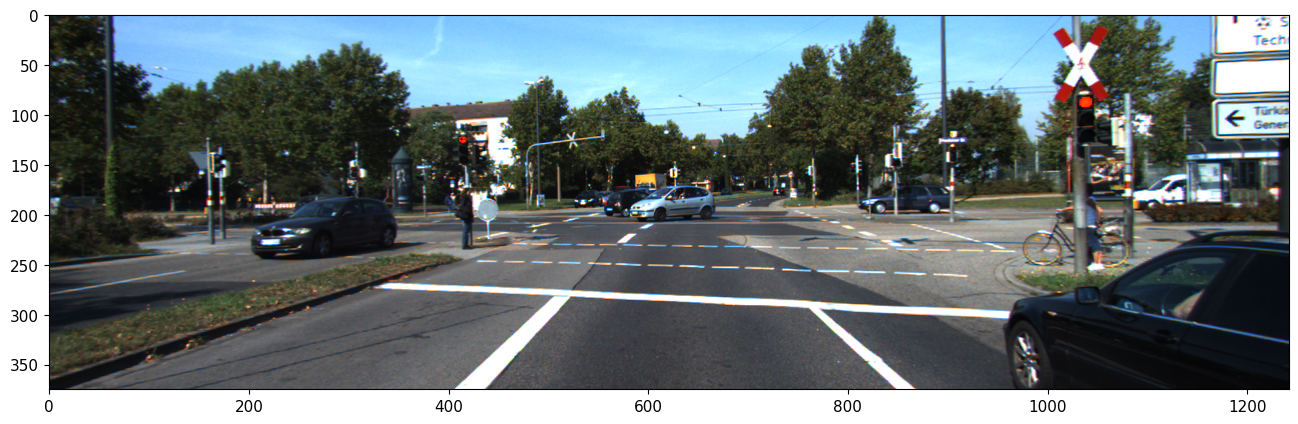

In [78]:
left_img_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,9))
plt.imshow(left_img_rgb)

In [79]:
disp_bm = compute_disparity_map(
    left_img, right_img, matcher='bm', rgb=True, verbose=True)

Matcher: BM | Disparity map computation time: 0.0219 seconds


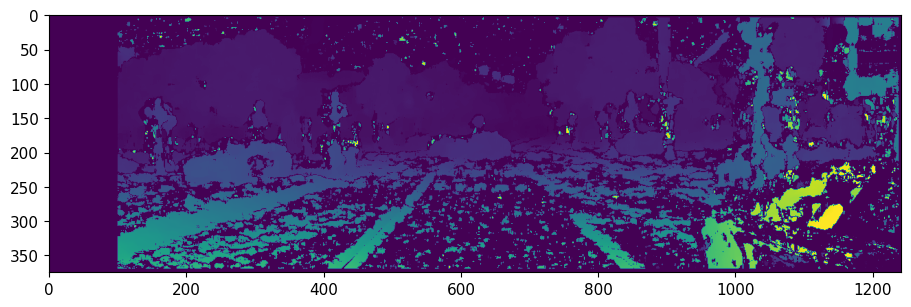

In [80]:
plt.figure(figsize=(11,7))
plt.imshow(disp_bm)

In [81]:
disp_sgbm = compute_disparity_map(
    left_img, right_img, matcher='sgbm', rgb=True, verbose=True)

Matcher: SGBM | Disparity map computation time: 0.0538 seconds


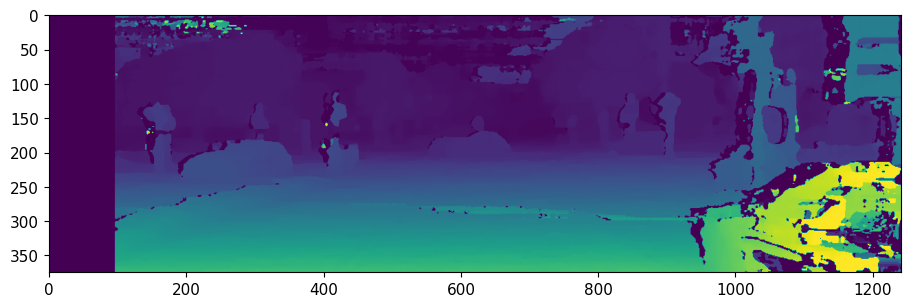

In [82]:
plt.figure(figsize=(11,7))
plt.imshow(disp_sgbm)

In [83]:
model = yolov5.load('yolov5s.pt')
model.conf = 0.25 # NMS confidence threshold 
model.iou = 0.45 # NMS IoU threshold
model.agnostic = False # NMS class agnostic
model.multi_label = False # NMS multiple labels per box 
model.max_det = 1000 # maximum number of detections per image

In [84]:
res = model(left_img_rgb, size=1280)

In [85]:
print(res)

image 1/1: 375x1242 3 persons, 1 bicycle, 7 cars, 6 traffic lights, 1 stop sign
Speed: 2.2ms pre-process, 4.9ms inference, 0.8ms NMS per image at shape (1, 3, 416, 1280)


In [86]:
# parse results 
predictions = res.pred[0]
boxes = predictions[:, :4] # x1, y1, x2, y2
scores = predictions[:, 4]
categories = predictions[:, 5]

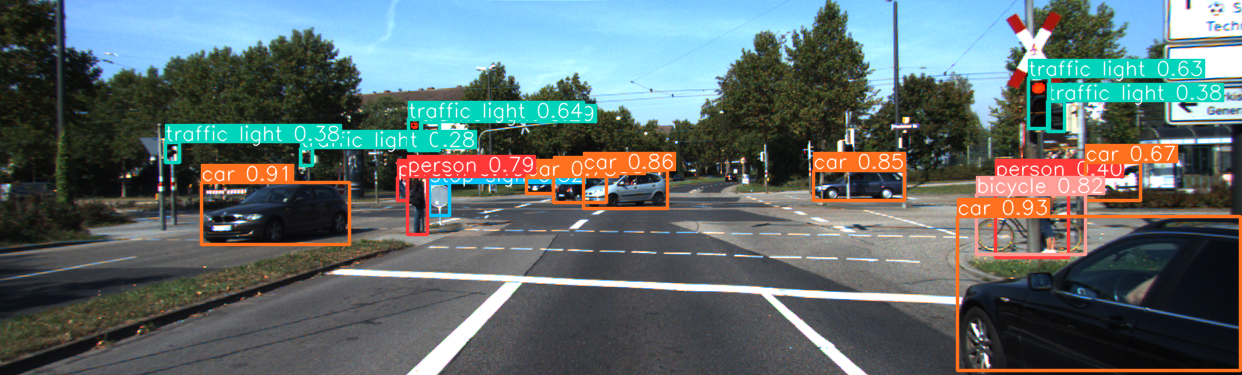

In [87]:
res.show()

In [88]:
print(boxes)

tensor([[ 957.69733,  216.16803, 1240.00000,  370.47192],
        [ 201.00494,  182.43867,  349.67163,  244.14490],
        [ 583.55713,  170.94684,  667.27429,  208.26740],
        [ 813.36493,  170.54897,  904.92175,  200.44615],
        [ 976.13031,  194.56186, 1085.01160,  254.06216],
        [ 407.31790,  173.55954,  427.65640,  234.13736],
        [ 526.05859,  177.81441,  553.75226,  193.65527],
        [1085.72559,  162.43593, 1140.04846,  200.52626],
        [ 408.98892,  119.40672,  421.65463,  150.96707],
        [1028.36462,   77.83776, 1049.02808,  128.62378],
        [ 553.85370,  174.55638,  606.36499,  202.95303],
        [ 397.51346,  177.63770,  407.83328,  200.45775],
        [ 995.42493,  177.39748, 1068.11829,  257.56696],
        [1047.69067,  101.50330, 1064.90186,  131.47194],
        [ 165.17969,  142.89911,  179.25328,  162.76405],
        [ 429.27277,  183.06903,  449.72888,  215.33455],
        [ 420.86414,  122.25305,  439.59869,  150.95546],
        [ 300.

In [94]:
box = boxes[0].cpu().numpy()

(154, 283, 3)


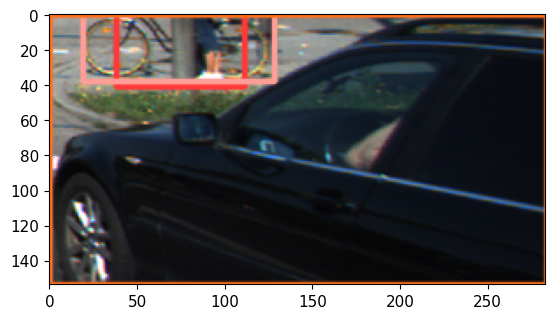

In [102]:
bbox = left_img_rgb[int(box[1]):int(box[3]), int(box[0]):int(box[2]), :]
print(bbox.shape)
plt.imshow(bbox)

In [ ]:
# a function to go through every box and get the min distance in that box 
# what to do with overlapping boxes?? cutout?
def object_distances(preds, disp_map): 
    
      
    return None 